# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [3]:
%pip install --upgrade keras
%pip install torch torchvision torchaudio datasets navec

In [4]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [5]:
import keras
print(keras.__version__)

3.0.5


In [6]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from navec import Navec
from tensorflow.keras.initializers import Constant
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
os.chdir("/content/drive/My Drive")

In [9]:
data = pd.read_csv('lenta_40k.csv')

In [10]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [13]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [15]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [16]:
MEAN_LEN = np.median([len(x) for x in X])

In [17]:
MAX_LEN = int(MEAN_LEN + 30)

In [18]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [19]:
X.shape

(44356, 200)

In [20]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [21]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

###1) модель с 1 GRU слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = keras.layers.GRU(64, return_sequences=False)(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - loss: 2.8096 - rec@prec: 9.4697e-07 - val_loss: 2.3445 - val_rec@prec: 0.0014
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 346ms/step - loss: 2.3256 - rec@prec: 5.7152e-05 - val_loss: 2.2365 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - loss: 2.1791 - rec@prec: 0.0015 - val_loss: 2.0496 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 340ms/step - loss: 1.9697 - rec@prec: 0.0159 - val_loss: 1.9033 - val_rec@prec: 0.0000e+00
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - loss: 1.7686 - rec@prec: 0.0606 - val_loss: 1.8621 - val_rec@prec: 0.0126
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - loss: 1.6175 - rec@prec: 0.1167 - val_loss: 1.8642 - val_rec@prec: 0.0252
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 340ms/step - loss: 1.5083 - rec@prec: 0.1797 - val_loss: 1.7888 - val_rec@prec: 0.0361
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - loss: 1.3694 - rec@pre

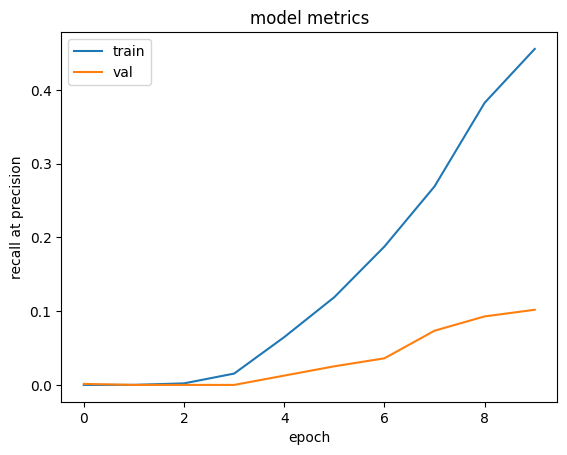

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###2) модель с 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = keras.layers.LSTM(64, return_sequences=False)(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 64)                  │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,345 (2.85 MB)

 Trainable params: 748,345 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - loss: 2.7410 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - loss: 2.3242 - rec@prec: 0.0000e+00 - val_loss: 2.2893 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - loss: 2.2441 - rec@prec: 3.0326e-04 - val_loss: 1.9920 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - loss: 1.9274 - rec@prec: 0.0152 - val_loss: 1.7635 - val_rec@prec: 0.0852
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - loss: 1.6977 - rec@prec: 0.1114 - val_loss: 1.6189 - val_rec@prec: 0.1330
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - loss: 1.6333 - rec@prec: 0.0748 - val_loss: 1.6363 - val_rec@prec: 0.0356
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - loss: 1.4959 - rec@prec: 0.1563 - val_loss: 1.5771 - val_rec@prec: 0.1344
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - loss: 1.3728 - rec

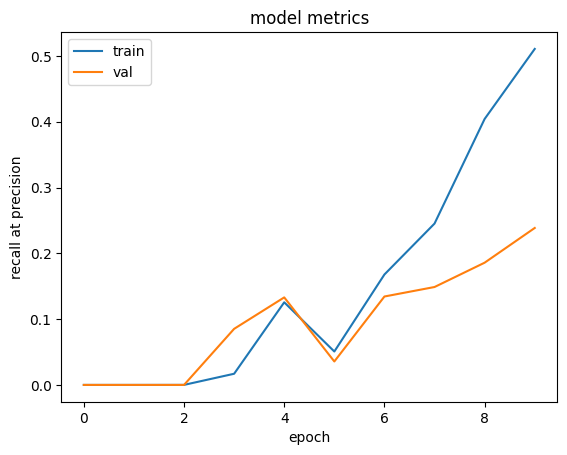

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=64)(inputs, )

gru_1 = keras.layers.GRU(64, return_sequences=True)(embeddings)
lstm_1 = keras.layers.LSTM(64, return_sequences=False)(gru_1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_1)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_12 (Embedding)             │ (None, 200, 64)             │       1,541,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_35 (GRU)                         │ (None, 200, 64)             │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,601,171 (6.11 MB)

 Trainable params: 1,601,171 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 593ms/step - loss: 2.7024 - rec@prec: 0.0000e+00 - val_loss: 2.3148 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 606ms/step - loss: 2.2899 - rec@prec: 3.2280e-04 - val_loss: 2.0119 - val_rec@prec: 0.0532
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 606ms/step - loss: 1.8469 - rec@prec: 0.0770 - val_loss: 1.6817 - val_rec@prec: 0.1930
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - loss: 1.4749 - rec@prec: 0.2814 - val_loss: 1.4475 - val_rec@prec: 0.2764
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 600ms/step - loss: 1.2630 - rec@prec: 0.4440 - val_loss: 1.4374 - val_rec@prec: 0.2543
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 600ms/step - loss: 1.1720 - rec@prec: 0.4897 - val_loss: 1.3472 - val_rec@prec: 0.3390
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 603ms/step - loss: 1.0440 - rec@prec: 0.6090 - val_loss: 1.4060 - val_rec@prec: 0.3282
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 592ms/step - loss: 0.9893 - rec@prec: 0.652

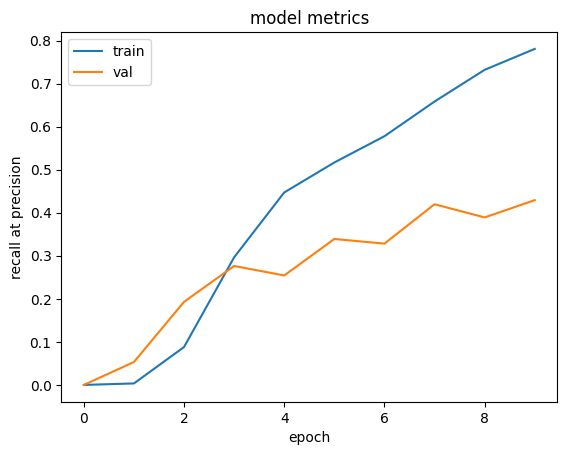

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True))(embeddings)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(bigru)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm2)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_13 (Embedding)             │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 200, 64)             │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 200, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 802,361 (3.06 MB)

 Trainable params: 802,361 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 2.6628 - rec@prec: 0.0000e+00 - val_loss: 2.3169 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 2.3264 - rec@prec: 0.0000e+00 - val_loss: 2.3108 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 2.2768 - rec@prec: 2.2738e-05 - val_loss: 1.9575 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 1.8905 - rec@prec: 0.0142 - val_loss: 1.7296 - val_rec@prec: 0.0834
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 1.6455 - rec@prec: 0.1179 - val_loss: 1.7160 - val_rec@prec: 0.1294
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 1.7126 - rec@prec: 0.0591 - val_loss: 1.6075 - val_rec@prec: 0.1298
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 1.4435 - rec@prec: 0.1666 - val_loss: 1.5277 - val_rec@prec: 0.1470
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 1.3460 - rec@prec: 0.1762 - val_loss

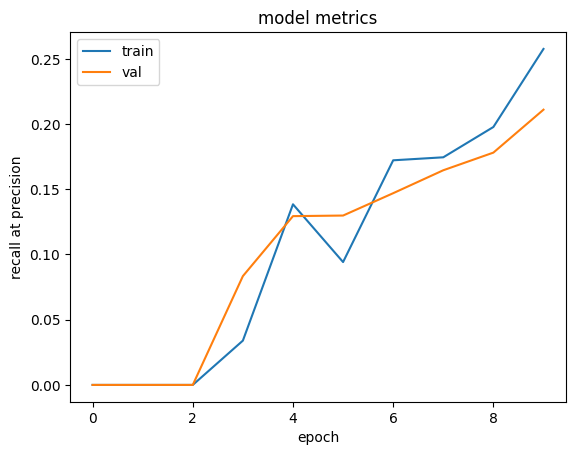

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###5) модель с 5 GRU слоями и 3 LSTM слоями

In [26]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru1 = keras.layers.GRU(32, return_sequences=True)(embeddings)
gru2 = keras.layers.GRU(32, return_sequences=True)(gru1)
lstm1 = keras.layers.LSTM(32, return_sequences=True)(gru2)
gru3 = keras.layers.GRU(32, return_sequences=True)(lstm1)
lstm2 = keras.layers.LSTM(32, return_sequences=True)(gru3)
gru4 = keras.layers.GRU(32, return_sequences=True)(lstm2)
lstm3 = keras.layers.LSTM(32, return_sequences=True)(gru4)
gru5 = keras.layers.GRU(32, return_sequences=False)(gru4)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru5)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 200, 32)             │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 200, 32)             │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 200, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 200, 32)             │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 200, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 200, 32)             │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 19)                  │             627 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771,545 (2.94 MB)

 Trainable params: 771,545 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 352s 8s/step - loss: 2.7568 - rec@prec: 0.0000e+00 - val_loss: 2.3370 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - loss: 2.3393 - rec@prec: 0.0000e+00 - val_loss: 2.3155 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - loss: 2.3239 - rec@prec: 0.0000e+00 - val_loss: 2.3146 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - loss: 2.3232 - rec@prec: 0.0000e+00 - val_loss: 2.3146 - val_rec@prec: 0.0000e+00
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - loss: 2.3215 - rec@prec: 0.0000e+00 - val_loss: 2.3127 - val_rec@prec: 0.0000e+00
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - loss: 2.3259 - rec@prec: 0.0000e+00 - val_loss: 2.3104 - val_rec@prec: 0.0000e+00
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 245s 6s/step - loss: 2.2725 - rec@prec: 0.0000e+00 - val_loss: 2.0805 - val_rec@prec: 0.0000e+00
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step - lo

###*Один раз, когда получилось запустить тетрадку с гпу тут был нормальный график, потому что юнитов было 128, но график почему-то не сохранился, а когда перезапускал на цпу с меньшим количеством юнитов, то график уже такой.*

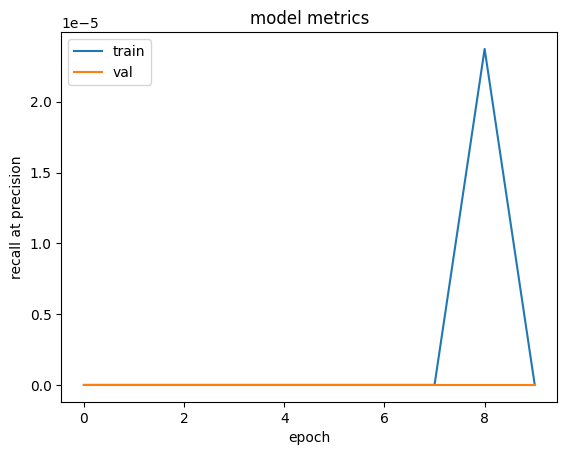

In [29]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались


In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_forward = keras.layers.GRU(32, return_sequences=True)(embeddings)
gru_backward = keras.layers.GRU(32, return_sequences=True, go_backwards=True)(embeddings)
bigru = keras.layers.concatenate([gru_forward, gru_backward])

lstm_forward = keras.layers.LSTM(32, return_sequences=False)(bigru)
lstm_backward = keras.layers.LSTM(32, return_sequences=False, go_backwards=True)(bigru)
lstm = keras.layers.concatenate([lstm_forward, lstm_backward])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru1 = keras.layers.GRU(128, return_sequences=True)(lstm1)
bilstm = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(gru1)
bigru = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True))(bilstm)
gru2 = keras.layers.GRU(128, return_sequences=True)(bigru)
lstm2 = keras.layers.LSTM(128, return_sequences=False)(gru2)

dense = keras.layers.Dense(64, activation='relu')(lstm2)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=10)

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Вообще, в тот мемент, когда удалось часть из этих моделей обучить на гпу, то лучший результат за 10 эпох показала последняя модель - там было под 0,9. При том, что я старался по возможности сохранять условия, такие как output_dim и число юнитов между моделями


##Задание 2 (6 баллов)

На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
dataset = load_dataset("tner/wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

In [ ]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
%pip install fasttext

In [ ]:
from huggingface_hub import hf_hub_download
import fasttext

model_fasttext = fasttext.load_model(hf_hub_download("facebook/fasttext-ru-vectors", "model.bin"))

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [ ]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
embedding_dim = model_fasttext.get_dimension()

embedding_matrix = np.zeros((len(word2id), embedding_dim))

In [ ]:
embedding_dim

300

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03028168, -0.08811525,  0.23132069, ..., -0.02347893,
         0.00095113, -0.02957203],
       [-0.01215426, -0.00385964, -0.00705711, ...,  0.01192162,
         0.02136094,  0.00374185],
       ...,
       [ 0.01883635, -0.0269728 , -0.05330423, ...,  0.03609481,
        -0.01099953, -0.07178792],
       [ 0.16461684, -0.11871357,  0.03160643, ..., -0.0197272 ,
         0.04651267,  0.11391385],
       [-0.02445162, -0.02752407,  0.00474452, ...,  0.01368786,
        -0.00281889, -0.01744165]])

In [ ]:
for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
      embedding_matrix[i] = model_fasttext.get_word_vector(word)

    except KeyError:
      # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
      continue
      embedding_matrix[i] = model_fasttext.get_word_vector('опрагпллирао')

    # if word in model_fasttext:
    #     embedding_matrix[idx] = model_fasttext.get_word_vector(word)
    # else:
    #     embedding_matrix[idx] = np.zeros(embedding_dim)
    #     pass

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03028168, -0.08811525,  0.23132069, ..., -0.02347893,
         0.00095113, -0.02957203],
       [-0.01215426, -0.00385964, -0.00705711, ...,  0.01192162,
         0.02136094,  0.00374185],
       ...,
       [ 0.01883635, -0.0269728 , -0.05330423, ...,  0.03609481,
        -0.01099953, -0.07178792],
       [ 0.16461684, -0.11871357,  0.03160643, ..., -0.0197272 ,
         0.04651267,  0.11391385],
       [-0.02445162, -0.02752407,  0.00474452, ...,  0.01368786,
        -0.00281889, -0.01744165]])

###1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

In [ ]:
import tensorflow as tf

In [ ]:
import gensim

In [ ]:
import gensim.downloader

In [ ]:
glove_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
# embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[embedding_matrix])(inputs, )

# embeddings = tf.keras.layers.Embedding(input_dim=300, output_dim=300, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)(inputs, )

embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0], output_dim=300, weights=[glove_vectors.vectors], input_length=MAX_LEN, trainable=False) (inputs)

bilstm1 = tf.keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm2 = tf.keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bilstm1)
bilstm3 = tf.keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False))(bilstm2)

# dense = keras.layers.Dense(64, activation='relu')(bilstm3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[-0.01921569, -0.04429   ,  0.01141533, ..., -0.06816524,
        -0.1113053 , -0.01868097],
       [-0.13945161,  0.00953103,  0.09669053, ...,  0.13606454,
        -0.01110533,  0.07058567],
       [-0.06355252,  0.03148742, -0.04285886, ..., -0.0162103 ,
        -0.06480815,  0.02475655],
       ...,
       [ 0.11291438,  0.0176115 ,  0.14802118, ...,  0.1615205 ,
        -0.01609856,  0.00853196],
       [ 0.02587008,  0.01879713,  0.04726784, ...,  0.02090296,
        -0.04752098, -0.03794819],
       [-0.04889952,  0.01550509, -0.03137619, ...,  0.0722907 ,
        -0.01641058,  0.04799879]], dtype=float32)], 'input_length': 54}

In [ ]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=128,
         epochs=5)

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = model.predict(X_test).argmax(2)

In [ ]:
pred

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [ ]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model)

In [ ]:
label_seq('Виктор, Семен, Петр, Арагорн, Осел', word2id, id2labels, MAX_LEN, model)

###2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                       weights=[embedding_matrix])(inputs)

bigru1 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru2 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(bigru1)
bigru3 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=False))(bigru2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(bigru3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=128,
         epochs=5)

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = model.predict(X_test).argmax(2)

In [ ]:
pred

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

In [ ]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model)

In [ ]:
label_seq('Виктор, Семен, Петр, Арагорн, Осел', word2id, id2labels, MAX_LEN, model)

###Выводы